In [41]:
#imports
import time
import qcportal as ptl
import numpy as np
import matplotlib.pyplot as plt
from fragmenter.utils import HARTREE_2_KJMOL
from fragmenter import chemi
from simtk import unit
import os, sys
from fragmenter import chemi
import cmiles
import qcportal as ptl
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openeye import oechem
from scipy import stats
import arch.bootstrap
import fragmenter 

# Analyze WBO Torsion

This script performs analysis on QCA datasets by finding the torsion barrier from their QCA record and calculating their ELF10 WBO with an AM1 calculation. 

## Data output
After data processing the molecules are stored into an oeb. Each respective OE molecule has the following data stored using datatags: 
 - tdr_object.id : int (id of the TD record) with datatag "TDid"
 - dihedral_indices: list (list of atom indices for which torsion is driven in this record) datatag "TDindices"
 - torsion_barrier: float (torsion barrier energy in KJ/mol, maximum of all the barriers) datatag "TB"
 - cmiles: str (string for the cmiles of the molecule in canonical_isomeric_explicit_hydrogen_mapped_smiles) datatag "cmiles"
 - wbo: float (float of the ELF10 wiberg bond order calculated between the central torsion idicies) datatag "wbo"
 - IDMatch: "IDMatch" that contain the torsion id from .offxml format FF involved in the QCA torsion drive datatag "IDMatch"

 
## Plotting 


In [54]:
#functions 
def torsion_barrier_for_molecule(tdr_object, smiles, show_plots=False):
    """
    Takes in a single torsion drive record that has energies from multiple conformers (at different torsion angles), evaluates the torsion barrier 
    
    Parameters
    ----------
    tdr_object : object
        torsion drive record from QC archive for a molecule
    
    Returns
    -------
    mol: oemol object
        oemol from the smiles in dataframe index that contains datatags with the following: 
        tdr_object.id : int (id of the TD record) with datatag "TDid"
        dihedral_indices: list (list of atom indices for which torsion is driven in this record) datatag "TDindices"
        torsion_barrier: float (torsion barrier energy in KJ/mol, maximum of all the barriers) datatag "TB"
        cmiles: str (string for the cmiles of the molecule in canonical_isomeric_explicit_hydrogen_mapped_smiles) datatag "cmiles"
    """
    energies = list(tdr_object.get_final_energies().values())
    tmp = list(tdr_object.get_final_energies().keys())
    angles = [i[0]*np.pi/180 for i in tmp]
    angles, energies = zip(*sorted(zip(angles, energies)))
    angles = np.array(angles)
    energies = np.array(energies)
    angles = np.append(angles[-3:] - 2*np.pi, np.append(angles, angles[:3] + 2*np.pi))
    energies = np.append(energies[-3:], np.append(energies, energies[:3]))
    
    idx = []
    for i in range(len(angles)-2):
        m1 = (energies[i+1]-energies[i])/(angles[i+1]-angles[i])
        m2 = (energies[i+2]-energies[i+1])/(angles[i+2]-angles[i+1])
        if np.sign(m1) == np.sign(m2):
            continue
        else:
            idx.append(i+1)
        
    if (show_plots):
        min_ener = min(energies)
        energies_y = (energies-min_ener)*HARTREE_2_KJMOL
        fontsize = 14
        plt.figure()
        plt.plot(angles*180/np.pi, energies_y, 'b-X', angles[idx]*180/np.pi, energies_y[idx], 'ro')
        plt.legend(['QM data', 'Max, min'], bbox_to_anchor=(1, 1), fontsize=fontsize)
        plt.title('Torsion drive interpolation', fontsize=fontsize)
        plt.xlabel('Dihedral Angle [Degrees]', fontsize=fontsize)
        plt.ylabel('Relative energy [KJ / mol]', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        fig_name = 'plot_' + tdr_object.id + '.png'
        plt.savefig(fig_name)
        plt.show()
        
    torsion_barriers = []
    for i in range(int(len(idx)-1)):
        torsion_barriers.append(abs(HARTREE_2_KJMOL*abs(energies[idx[i]] - energies[idx[i+1]])))
    torsion_barriers = np.array(torsion_barriers)
    
    # get dihedral indices and pass on to get_wbo function
    dihedral_indices = list(tdr_object.dict()['keywords']['dihedrals'][0])
    mol = chemi.smiles_to_oemol(smiles)
    mol.SetData("TB", max(torsion_barriers))
    mol.SetData("TDindices", dihedral_indices)
    mol.SetData("TDid", tdr_object.id)
    mol.SetData("cmiles", smiles)
    
    return mol

    

def loadDataset_low(datasetName, specification):
    """
    Low level call to load each torsion drive dataset and return a list of molecules
    
        Parameters
        ----------
        datasetName : str
            torsion drive dataset name.  
        specification : str
            specification in the dataset. Example: "B3LYP-D3", "default", "UFF" 
        
        Returns
        -------
        molList : list of objects
            each row contains the tdr_object.id, dihedral_indices, torsion_barrier, oemol_object
    """
    while True:    
        try:
            assert(datasetName)
            break
        except AssertionError:
            print ("datasetName is empty. Check input list of dataset tuples")
            raise
    while True:    
        try:
            assert(specification)
            break
        except AssertionError:
            print ("specification is empty. Check input list of dataset tuples")
            raise

    # initiate qc portal instance
    client = ptl.FractalClient()    
    # from the TorsionDriveDataset collection picking up given datasetName
    ds = client.get_collection("TorsionDriveDataset", datasetName)
    ds.status([specification], status="COMPLETE")
 
    # Serial implementation
    tb = []
    for i in range(ds.df.size):
        if (ds.df.iloc[i,0].status == 'COMPLETE'):
            smiles = ds.df.index[i]
            mapped_smiles = ds.get_entry(smiles).attributes['canonical_isomeric_explicit_hydrogen_mapped_smiles']
            tb.append(torsion_barrier_for_molecule(ds.df.iloc[i, 0], mapped_smiles))
    #print("Total records processed for this dataset:", len(tb), "out of ", len(ds.df))
    return(tb)




def checkTorsion(molList):
    """
    Take mollist and check if the molecules in a list match a specific torsion id
    
        Parameters
        ----------
        molList : List of objects
            List of oemols with datatags generated in genData function

        Returns
        -------
        molList : list of objects
            List of oemol objects that have a datatag "IDMatch" that contain the torsion id involved in the QCA torsion drive 
    """

    matches=[]
    count=0
    mols=[]
    for mol in molList: 
        molecule = Molecule.from_mapped_smiles(mol.GetData("cmiles"))
        #molecule=Molecule.from_openeye(mol)
        topology = Topology.from_molecules(molecule)
        # Let's label using the Parsley force field
        forcefield = ForceField('openff-1.2.1.offxml')
        # Run the molecule labeling
        molecule_force_list = forcefield.label_molecules(topology)
        params=[]
        # Print out a formatted description of the torsion parameters applied to this molecule
        for mol_idx, mol_forces in enumerate(molecule_force_list):
            #print(f'Forces for molecule {mol_idx}')
            for force_tag, force_dict in mol_forces.items():
                if force_tag == 'ProperTorsions':
                    for (atom_indices, parameter) in force_dict.items():
                        atomList=[]
                        for idx in atom_indices:
                            atomList.append(idx)
                        params.append(parameter.id)
                        if atomList == mol.GetData("TDindices") or atomList[::-1] == mol.GetData("TDindices"):
                            count+=1
                            mol.SetData("IDMatch", parameter.id)
                            mols.append(mol)
    #print(count)
    print("Out of " +str(len(molList)) + " molecules, " + str(count) + " were processed with torsion data")
    
    return mols 



def calcWBO(molList):
    """
    Take mollist and calculate the wbo for central bond located for the torsion idices 
    
        Parameters
        ----------
        molList : List of objects
            List of oemols with datatags generated in genData function

        Returns
        -------
        molList : list of objects
            List of oemol objects that have a datatag "wbo" that contain am1 ELF10 WBO 
    """

    mols=[]
    errors=[]
    for mol in molList:
        charged = chemi.get_charges(mol)
        for bond in charged.GetBonds():
            m1=bond.GetBgnIdx()
            m2=bond.GetEndIdx()
            index=mol.GetData("TDindices")
            # DEBUGGING: ERROR IS HAPPENING HERE
            # ISSUE WITH INDEX, ROWLEY DATASET IS NOT FINDING MATCH TO TORSION INDICES FOR ANY 
            if m1 in [index[1], index[2]]:
                if m2 in [index[1], index[2]]:
                    #print("match")
                    #if (m1 in map_idx or m2 in map_idx) and not bond.IsInRing():
                    try: 
                        wbo = bond.GetData('WibergBondOrder')
                        mol.SetData("WBO", wbo)
                        mols.append(mol)
                    except Exception as e: 
                        print(e)
                        errors.append(mol)
                        pass
                else:
                    print("no match")
            else:
                print("no match")
    
    print("Out of " +str(len(molList)) + " molecules, " + str(len(mols)) + " were processed with WBO")
    return mols, errors
    


def makeOEB(oemolList, tag):
    """
    Take mollist and create oeb file using the tag as the .oeb file name  
    
        Parameters
        ----------
        molList : List of objects
            List of oemols with datatags generated in genData function
        tag : String
            Title of the oeb file 

        Returns
        -------
    """
    ofile = oechem.oemolostream(tag+'.oeb')
    for mol in oemolList:
        oechem.OEWriteConstMolecule(ofile, mol)
    ofile.close()
    return



def compute_r_ci(wbos, max_energies):
    return (stats.linregress(wbos, max_energies)[2])**2


def oeb2oemol(oebfile):
    """
    Takes in oebfile and generates oemolList
        Parameters
        ----------
        oebfile : String
            Title of an oeb file
        Returns
        -------
        mollist : List of objects
            List of OEMols in the .oeb file
            
    """
    ifs = oechem.oemolistream(oebfile)
    mollist = []

    for mol in ifs.GetOEGraphMols():
            mollist.append(oechem.OEGraphMol(mol))

    return mollist



#plotting functions
def genPlots(fileName, fname):
    """
    Generates a .pdf plot from a .oeb file of wbo versus torsion barrier height 
        Parameters
        ----------
        fileName : String
            .oeb file name for the molecules that contain datatags with plotting information
        fname : String
            The output .pdf file name for the resulting files from the plotting function 

        Returns
        -------
    """

    molList=oeb2oemol(fileName)
    
    torsionDict={}
    #print(molList)
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]={}
        torsionDict[tid]['tb']=[]
        torsionDict[tid]['wbo']=[]
    #print(torsionDict)
    
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]['tb'].append(m.GetData("TB"))
        torsionDict[tid]['wbo'].append(m.GetData("WBO"))
    #print(torsionDict)
    
    
    
    colors = fragmenter.chemi._KELLYS_COLORS
    #fig, ax = plt.subplots()
    
    fig,ax=plt.subplots()

    for i, (key, item) in enumerate(torsionDict.items()):
        ax.scatter(torsionDict[key]['wbo'],torsionDict[key]['tb'],c=colors[i], label=key)
        slope, intercept, r_value, p_value, std_err = stats.linregress(torsionDict[key]['wbo'], torsionDict[key]['tb'])
        #print(key)
        #print(r_value)
        #print(slope)
        #print(intercept)
        ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(torsionDict[key]['wbo']), np.asarray(torsionDict[key]['tb'])).conf_int(compute_r_ci, 1000)
        CI_95 = 1.96*std_err
        plt.plot(np.unique(torsionDict[key]['wbo']), np.poly1d([slope, intercept])(np.unique(torsionDict[key]['wbo'])), c=colors[i])
    
    l = ax.legend(bbox_to_anchor=(1, 1), fontsize=14)

    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    


def visualize_wbo_correlation_compare(fileName, fileName2, fname):
    """
    Generates a .pdf plot from a .oeb file of wbo versus torsion barrier height for two datasets 
    
        Parameters
        ----------
        fileName : String
            .oeb file name for the molecules that contain datatags with plotting information
        fileName2 : String
            .oeb file name for the molecules that contain datatags with plotting information. This dataset
            must have less torsion parametrs than fileName2
        fname : String
            The output .pdf file name for the resulting files from the plotting function 

        Returns
        -------
    """
    molList=oeb2oemol(fileName)
    torsionDict={}
    torsionDict2={}

    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]={}
        torsionDict[tid]['tb']=[]
        torsionDict[tid]['wbo']=[]
        torsionDict2[tid]={}
        torsionDict2[tid]['tb']=[]
        torsionDict2[tid]['wbo']=[]
    
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]['tb'].append(m.GetData("TB"))
        torsionDict[tid]['wbo'].append(m.GetData("WBO"))
    
    
    molList2=oeb2oemol(fileName2)
    
    for m in molList2:
        tid=m.GetData("IDMatch")
        torsionDict2[tid]={}
        torsionDict2[tid]['tb']=[]
        torsionDict2[tid]['wbo']=[]
    
    
    for m in molList2:
        tid=m.GetData("IDMatch")
        torsionDict2[tid]['tb'].append(m.GetData("TB"))
        torsionDict2[tid]['wbo'].append(m.GetData("WBO"))
    
    
    colors = fragmenter.chemi._KELLYS_COLORS
    
    fig,ax=plt.subplots()

    for i, (key, item) in enumerate(torsionDict.items()):
        ax.scatter(torsionDict[key]['wbo'],torsionDict[key]['tb'],c=colors[i], label=key, marker='o')
        ax.scatter(torsionDict2[key]['wbo'],torsionDict2[key]['tb'],c=colors[i], marker='x')
        slope, intercept, r_value, p_value, std_err = stats.linregress(torsionDict[key]['wbo']+torsionDict2[key]['wbo'], torsionDict[key]['tb']+torsionDict2[key]['tb'])
        #print(key)
        #print(r_value)
        #print(slope)
        #print(intercept)
        ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(torsionDict[key]['wbo']+torsionDict2[key]['wbo']), np.asarray(torsionDict[key]['tb']+torsionDict2[key]['tb'])).conf_int(compute_r_ci, 1000)
        CI_95 = 1.96*std_err
        plt.plot(np.unique(torsionDict[key]['wbo']+torsionDict2[key]['wbo']), np.poly1d([slope, intercept])(np.unique(torsionDict[key]['wbo']+torsionDict2[key]['wbo'])), c=colors[i])
    
    l = ax.legend(bbox_to_anchor=(1, 1), fontsize=14)
    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    

#main dataset generation function 
def genData(dsName, fileName):
    """
    Generates oeb files for the QCA datasets and plots that analyze WBO versus torsion barrier
    """
    molList=loadDataset_low(dsName, "default")
    mols1=checkTorsion(molList)
    molsWBO= calcWBO(mols1)
    makeOEB(molsWBO[0], fileName)
    makeOEB(molsWBO[1], "errors_" + fileName)


Out of 43 molecules, 43 were processed with torsion data
Out of 43 molecules, 43 were processed with WBO


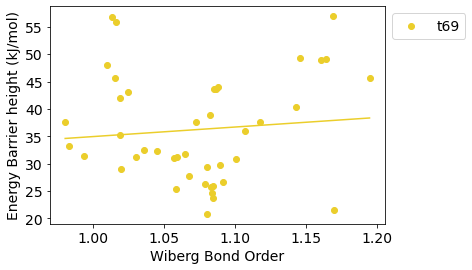

In [43]:
#An example of generating data and plotting for the Fragment Stability Benchmark 
genData("Fragment Stability Benchmark", "fragmentstability")
genPlots('fragmentstability.oeb', "fragmentstability.pdf")

Out of 43 molecules, 43 were processed with torsion data
Out of 43 molecules, 43 were processed with WBO


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scala

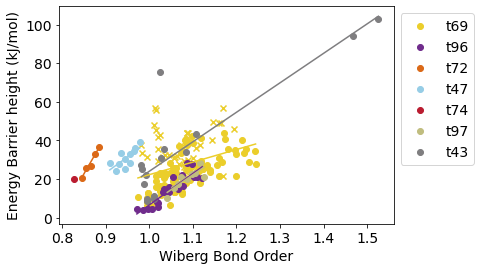

In [45]:
#An example of combining and comparing two datasets, let's try comparing with the phenyl dataset 
genData("OpenFF Substituted Phenyl Set 1", "phenyl")
visualize_wbo_correlation_compare('phenyl.oeb', 'fragmentstability.oeb', "fragmentStability_and_phenyl.pdf")

In [ ]:
#Let's also add the Rowley dataset and compare 
#DEBUGGING ROWLEY DATASET

genData("OpenFF Rowley Biaryl v1.0", "rowley")
visualize_wbo_correlation_compare('phenyl.oeb', 'rowley.oeb', "rowley_and_phenyl.pdf")

Out of 86 molecules, 86 were processed with torsion data
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no matc

no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
no match
